# Phase-Only Multi-Oscillator Model with AVP

In [2]:
# imports first! just the usual
import numpy as np
from scipy import integrate
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time

## Background and Math

### Topics from Previous Week

We are going to implement a model in which each neuron is simply tracking the angle of its clock hand. Without any signaling, each neuron has the following ODE

$$\frac{d\phi}{dt} = \omega$$

where $\phi$ is an angle in radians and $\omega$ is the intrinsic speed. A 24-h oscillator would have $\omega = \frac{2\pi}{24} = \frac{\pi}{12}$.

But, in the SCN, neurons are connected and receive signals that affect the speed of each clock. The most important of these is VIP. We have an idea of how VIP affects the phase of each neuron because Sungwon An (in the lab of Erik Herzog) collected a PRC to VIP (An et al, 2011). 


The PRC to VIP is show in Figure 1D:

<div style="max-width:300px;margin-left: auto; margin-right: auto;">

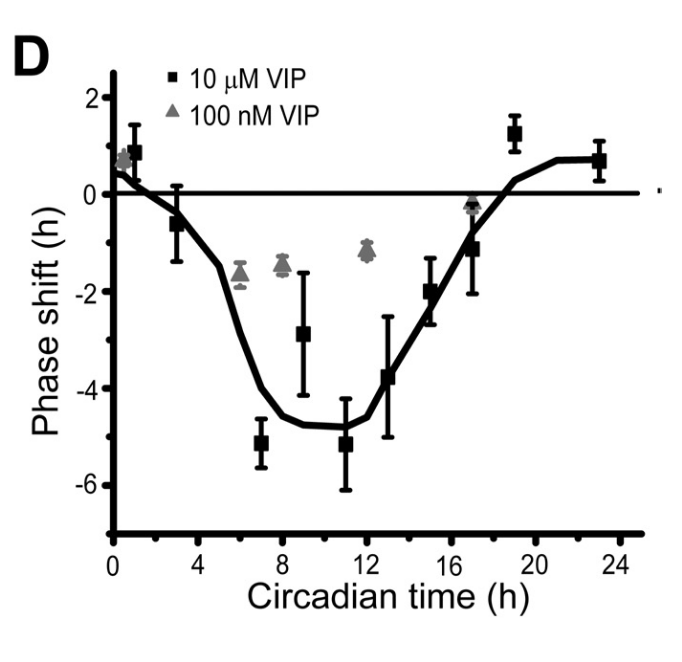
</div>

We see that the PRC is mostly delays and that the largest delay is at the end of the (CT12). I am going to make the assumption that this PRC (to an addition of VIP to the system) gives us the basic shape of the VRC. I am going to use a cosine curve for the sake of simplicity.

This makes the model more complicated. For the ith oscillator, we have

$$\frac{d\phi_i}{dt} = \omega + VRC(\phi_i(t)) \cdot VIPin_i(\vec{\phi(t)})$$

where $VIPin_i$ is the amount of VIP received by the ith oscillator. It is determined by the phases of the neurons that send VIP to neuron $i$ and by the amount of VIP being sent.

To determine $VIPin_i$ (a scalar), we need info about which neurons send how much VIP to neuron $i$. We will to represent the VIP coupling network with an adjacency matrix $A$. If there are $N$ neurons in the network, then the coupling network is $N \times N$. The entry $A_{i,j}$ gives us the fraction of VIP coming from neuron $j$ to neuron $i$ (so the columns indicate which neuron a signal is coming **from** and the rows indicate which neuron a signal is going **to**). We have a vector $\vec{VIPout}$ that contains the 1 in the jth location if VIP is being sent by neuron $j$ at that time. Then, we use matrix-vector multiplication to compute $\vec{VIPin}$.

<div style="max-width:300px;margin-left: auto; margin-right: auto;">

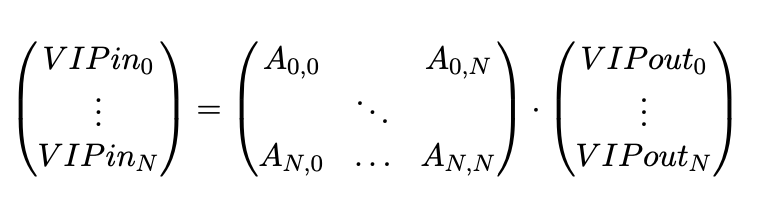
</div>

So, I write the entire model as

$$\frac{d\phi_i}{dt} = \omega + VRC(\phi_i(t)) \cdot VIPin_i(\vec{\phi(t)})$$

where

$$VIPin(\vec{\phi(t)}) = A \cdot VIPout(\vec{\phi(t)})$$

where $VIPout_j(\phi_j(t)) = 1$ if $\phi_j$ is in a given range and $0$ otherwise. Since VIP is day-active, it makes sense to have each cell output it during the day (that is CT0 to CT12, which is $\phi=0 to $\phi=\pi$.

### Adding AVP this week

Arginine vasopressin (AVP) is a second, important neuropeptide in the SCN. It has been shown that removing the ability for neurons to receive AVP affects the response to jetlag, but not the PRC to light or the synchrony (Yamaguchi et al, 2013). AVP is sent from neurons in the shell to other neurons in the shell and possibly neurons in the core of the SCN (there is conflicting evidence regarding AVP being sent to VIP neurons).

We are going to add AVP to our model today. To do, we need an AVP network and a VRC to AVP. Fortunately, we have a PRC to AVP collected by Kayla Rohr in the lab of Jenn Evans (Rohr et al, 2021).

<div style="max-width:300px;margin-left: auto; margin-right: auto;">

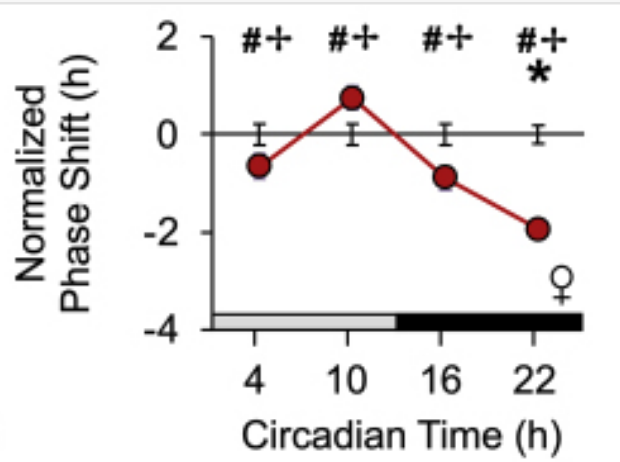
</div>



*References*

An, S., Irwin, R. P., Allen, C. N., Tsai, C. A. & Herzog, E. D. Vasoactive intestinal polypeptide requires parallel changes in adenylate cyclase and phospholipase C to entrain circadian rhythms to a predictable phase. Journal of Neurophysiology 105, 2289–2296 (2011).

Rohr, K. E., Inda, T. & Evans, J. A. Vasopressin resets the central circadian clock in a manner influenced by sex and vasoactive intestinal polypeptide signaling. Neuroendocrinology (2021) doi:10.1159/000521286.

Yamaguchi, Y. et al. Mice Genetically Deficient in Vasopression V1a and V1b Receptors Are Resistant to Jet Lag. Science 342, (2013).



### VRC code (last week)

Let's start by generating a function that will produce a VIP PRC like that observed experimentally.

In [3]:
# This is function SRT grabbed from her jetlag paper.
# It is more adjustable than we need at the moment, but we will
# use it regardless.
# VRC that adjusts the area under a cosine curve.
# for VIP, shift_rad should be 0 rad
# for AVP, the ideal shift_rad is pi (half out of phase)
def VRC_adjustable3(phi,Darea,Aarea,shift_rad):
    phase = np.mod(phi+shift_rad,2*np.pi)
    if phase >= np.pi/2 and phase < np.pi/2+np.pi:
        # in the delay section
        a = Darea/0.5
    else:
        # in the advance section
        a = Aarea/0.5;
    VRC = a * np.cos( phase )
    return VRC

Plot the VRC that we will use by default. We will not have it be too delay-heavy. This is a simplifying assumption, and this is something that should be adjusted (explored this semester)

Text(0.5, 1.0, 'VRC')

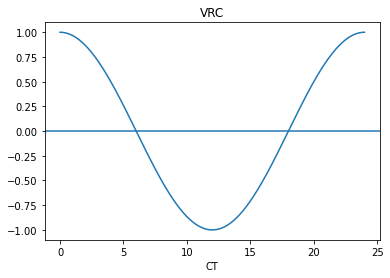

In [4]:
# Plot it!
VIP_Darea = 0.5
VIP_Aarea = 1-VIP_Darea
phis = np.arange( 0, 2*np.pi, 0.01 )
CTs = (12/np.pi)*phis
VIP_VRC = np.array( [VRC_adjustable3(p,VIP_Darea,VIP_Aarea,0) for p in phis] ).reshape( (phis.size,) )
plt.plot( CTs, VIP_VRC )
plt.axhline()
plt.xlabel( "CT");
plt.title( "VRC")

*Activity*

This week, we will be using the VRC for AVP as well. Its phase of response is different from that of the VIP VRC. It has advances during the day instead of delays during the day, so we are going to make the simplifying assumption that is is anti-phase from the VIP VRC. That means that is it $\pi$ out of phase. We indicate that by adding $\pi$ to the phase before we computer the cosine. There is a parameter to control this shift - shift_rad.


In [1]:
# Use a shift_rad of np.pi to plot the AVP VRC

### Adjacency matrix for VIP coupling network (last week)

The VIP coupling network is rather complicated, so let's write a function to create it. 

For a network to be connected, every cell must receive an input. In this case, a very few cells are supplying the output. Let's create the sparsest network possible - each neuron receives VIP from exactly one VIP cell. 

In our version 1 of the network, we will assume VIP cells don't receive VIP. There is biological evidence for this, but we will soon find this isn't the best assumption (hence, V2 of this function below).

In [25]:
# 10% of cells are VIP, and they are in the core. no reason not to put them next to each other because there is no local network among them.
# each cell receives VIP from exactly one VIP cell
# The key difference between this model and v1 is that VIP cells
# signal each other.
# In this model, the averaging is built into the matrix. In the mechanistic model, it isn't
# indexing: to, from
def VIP_conn_v2( N, VIP_strength ):
    if VIP_strength < 1e-8:
        return np.zeros( (N,N) )
    VIPcount = int( 0.1*N)
    half = N // 2
    A = np.zeros( (N,N) )
    for i in range(VIPcount):
        # to, from
        # every nonVIP cell gets input from one VIP cell
        A[VIPcount+i::VIPcount,i] = VIP_strength
        # Each VIP cell gets input from its neighbor in a 
        # circle
        A[(i+1)%VIPcount,i] = VIP_strength
    denom = np.count_nonzero( A, axis=1 )
    for i in range(denom.size):
        if denom[i] > 0:
            A[i,:] = A[i,:] / denom[i]
    return A



### Code to plot a network (last week)

Check out the fancy curves.

In [14]:
def plot_network(conn, N, half, rows, cols, title=None):
    VIP_count = int(0.1*N)
    AVP_count = int(0.2*N)
    AVP_skip = 3 # 1/0.2/2 (20% of cells, but only shell cells and shell cells are 50% of cells. so it would be every 5th cell overall, but instead is every 2.5th so round to every 3rd
    plt.figure()
    for i in range(N):
        r1,c1 = np.unravel_index( i, (rows,cols))
        for j in range(N):
            if conn[i,j] > 0:
                r2,c2 = np.unravel_index( j, (rows,cols))
#                 plt.plot( (c1,c2), (r1,r2), 'k-' )
                if c1 > c2:
                    # arrow goes from c2 to c1, so it goes from right to left
                    cdiff = c1-c2-0.05
                elif c1 == c2:
                    cdiff = c1-c2
                else:
                    cdiff = c1-c2+0.05
                if r1 > r2:
                    # arrow goes from r2 to r1, so it goes up
                    rdiff = r1-r2-0.05
                elif r1 == r2:
                    rdiff = r1-r2
                else:
                    rdiff = r1-r2+0.05
#                 plt.arrow( c2, r2, cdiff, rdiff, color='k', alpha=0.5, head_width=0.1 )

                x1 = c2
                y1 = r2
                x2 = c2+cdiff
                y2 = r2+rdiff
                style = "Simple, tail_width=0.5, head_width=4, head_length=8"
                kw = dict(arrowstyle=style, color="k", alpha=0.5)
                arrow = patches.FancyArrowPatch((x1, y1), (x2, y2),
                             connectionstyle="arc3,rad=.25", **kw)
                plt.gca().add_patch(arrow)                    
        if i < half:
            plt.plot( c1, r1, 'ro')
            # VIP cells are 10% of the cells and they are clustered in the core
            if i < VIP_count:
                plt.plot( c1, r1, 'yv' )
        else:
            plt.plot( c1, r1, 'bo')
            # AVP cells are 20% of the cells and they are spread out throughout the shell
            if np.mod(i-half, AVP_skip) == 0:
                plt.plot( c1, r1, 'm^' )
        if title is not None:
            plt.title(title)

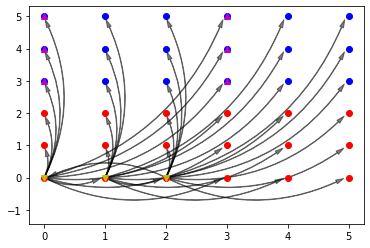

In [27]:
N = 36
VIP_strength = 1
half = N//2
rows = int(np.sqrt(N))
cols = int(N/rows)

VIPconn = VIP_conn_v2( N, VIP_strength )
plot_network( VIPconn, N, half, rows, cols )
plt.show()

### Adjacency matrix for AVP coupling network (this week)

The AVP coupling network is rather complicated, and we are going to need to make and vary assumptions about it. Let's start with the simplest set.

We know that about 20% of neurons in the SCN are AVPergic and that they are located in the shell (Ono et al, 2021), we will will spread those AVP cells throughout the second half of our network.

Further, the AVP network may be more local than the VIP network (though the evidence is NOT clear to SRT for this one). We will construct it so that AVP is sent to cells that are nearby in our 2D grid. This is another area of adjustment for the model.

*Reference*

Ono, D., Honma, K. I. & Honma, S. Roles of Neuropeptides, VIP and AVP, in the Mammalian Central Circadian Clock. Frontiers in Neuroscience 15, 1–8 (2021).


In [8]:
# 20% of cells are AVP, and they are in the shell. make them every 3rd cell.
# Construct an AVP network with only local coupling a nbrhood_size of 1
# means that each AVP cell sends a signal to its neighbors 1 way up/down/left/right/diagonal
# nbrhood size of 2 means that more than half of the cells receive AVP
def AVP_conn_v1( N, AVP_strength, nbrhood_size = 2 ):
    rows = int(np.sqrt(N))
    cols = int(N/rows)
    half = N//2
    AVP_count = int(0.2*N)
    AVP_skip = 3 # 1/0.2/2 (20% of cells, but only shell cells and shell cells are 50% of cells. so it would be every 5th cell overall, but instead is every 2.5th so round to every 3rd
    AVPconn = np.zeros( (N,N) )
    #for j in range(half,half+AVP_count): # AVP cells at beginning of shell
    for j in range(half,N, AVP_skip): # AVP cells spread throughout shell
        # from nodes.
        r,c = np.unravel_index( j, (rows,cols) )
        neighbors = []
        for nridx in range(nbrhood_size+1):
            for ncidx in range(nbrhood_size+1):
                if nridx == 0 and ncidx == 0:
                    continue # no self-signaling
                neighbors.extend([(r-nridx,c-ncidx),(r+nridx,c+ncidx)])
        for nbr in neighbors:
            if nbr[0] >= 0 and nbr[0] < rows and nbr[1] >= 0 and nbr[1] < cols:
                i = np.ravel_multi_index( nbr, (rows,cols) )
                AVPconn[i,j] = AVP_strength
    denom = np.count_nonzero( AVPconn, axis=1 )
    for i in range(denom.size):
        if denom[i] > 0:
            AVPconn[i,:] = AVPconn[i,:] / denom[i]
    return AVPconn


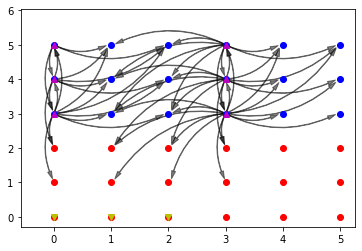

In [16]:
N = 36
AVP_strength = 0.3
half = N//2
rows = int(np.sqrt(N))
cols = int(N/rows)

AVPconn = AVP_conn_v1( N, AVP_strength )
plot_network( AVPconn, N, half, rows, cols )
plt.show()

*Activity*

Describe the difference between the VIP and AVP networks.

*Activity*

Adjust the neighborhood size and plot the results. Also, describe what a neighborhood is.

In [ ]:
# Your code here

### Make the model (updated this week)

First we have a class that will hold all the parameters

- an intrinsic speed for each oscillator
- Phases during which VIP is output
- Phases during which AVP is output (NEW!)
- balance of D and A areas under VIP VRC
- balance of D and A areas under AVP VRC and its phase (NEW!)


Then, we write the model code and a function that will plot the output of the model

In [34]:
class Parameters_VipAVP:
    def __init__( self, N, VIPconn, AVPconn, intrinsic_periods = None, AVP_VRC_shift=np.pi, VIP_duration= np.pi/2 ):
        half = N // 2
        if intrinsic_periods is None:
            np.random.seed( 0 )
            intrinsic_periods = np.random.randn( N ) * 0.5
            intrinsic_periods[:half] += 25
            intrinsic_periods[half:] += 24.4
        # Assume that VIP is sent during day (pretty confident about this assumption)
        VIP_active_start = np.pi/2-VIP_duration/2;
        VIP_active_stop = VIP_active_start+VIP_duration; 
        VIP_Darea = 0.5;
        # Assume that AVP is sent during day, just like VIP. Is that a good assumption?
        # AVP levels in cerebrospinal fluid higher in morning than at night (Reppert et al, Science 1981), so it might be fine.
        # This is something we can adjust
        AVP_duration = np.pi/2;
        AVP_active_start = np.pi/2-AVP_duration/2;
        AVP_active_stop = AVP_active_start+AVP_duration; 
        AVP_Darea = 0.5;
        self.N = N
        self.VIPconn = VIPconn
        self.AVPconn = AVPconn
        self.intrinsic_speeds = np.reshape( (2*np.pi)/intrinsic_periods, (N,) )
        self.params = np.array( [VIP_Darea, VIP_active_start, VIP_active_stop, AVP_Darea, AVP_VRC_shift, AVP_active_start, AVP_active_stop] )
        
        

In [29]:
# Model function to be used by solve_ivp
# t is a scalar (time)
# phi is the vector of phases for each cell
# pobj is the Parameters_VipOnly object 
def model_vip_avp(t,phi,pobj):
    N = pobj.N
    phi = np.mod(phi,2*np.pi);
    VIP_Darea = pobj.params[0] # fraction of total area
    VIP_Aarea = 1-VIP_Darea # fraction of total area
    VIP_active_start = pobj.params[1]
    VIP_active_stop = pobj.params[2]
    AVP_Darea = pobj.params[3] # fraction of total area
    AVP_Aarea = 1-VIP_Darea # fraction of total area
    AVP_VRC_shift = pobj.params[4]
    AVP_active_start = pobj.params[5]
    AVP_active_stop = pobj.params[6]

    speed = pobj.intrinsic_speeds

    # Evaluate the VIP VRC at the phase for each of the oscillators
    VIP_VRC = np.array( [VRC_adjustable3(p,VIP_Darea,VIP_Aarea,0) for p in phi] ).reshape( (N,) )
    VIP_output = np.zeros( (N,) )
    VIP_output[np.logical_and( VIP_active_start <= phi, phi <= VIP_active_stop )] = 1
    AVP_VRC = np.array( [VRC_adjustable3(p,AVP_Darea,AVP_Aarea,AVP_VRC_shift) for p in phi] ).reshape( (N,) )
    AVP_output = np.zeros( (N,) )
    AVP_output[np.logical_and( AVP_active_start <= phi, phi <= AVP_active_stop )] = 1

    # This code makes it look like we sum the input, but the connectivity matrix is set up so that
    # each entry has already been divided by the number of entries that send to a particular cell
    VIP_input = pobj.VIPconn @ VIP_output
    AVP_input = pobj.AVPconn @ AVP_output

    dydt = speed + VIP_VRC*VIP_input + AVP_VRC*AVP_input
    return dydt


In [30]:
# Plot the output of the model
#  pobj is the Parameters_VipAVP object
#  sol is the output of solve_ivp
def plot_VIP_AVP( pobj, sol ):
    VIPsenders = pobj.VIPconn.sum(axis=0)
    phi = np.mod( sol.y, 2*np.pi )
    MP = np.sin( sol.y )
    plt.subplot( 3, 1, 1 )
    plt.plot( ts, phi.T )
    plt.plot( ts, phi[np.nonzero(VIPsenders)[0],:].T, 'y' )
    plt.ylabel( 'phi mod 2pi')
    plt.subplot( 3, 1, 2 )
    plt.plot( ts, MP.T, 'k', alpha=0.5 )
    plt.plot( ts, MP[np.nonzero(VIPsenders)[0],:].T, 'y' )
    plt.ylabel( 'Per mRNA')
    plt.subplot( 3, 1, 3 )
    dphidt = np.diff( sol.y.T, axis=0 )/(ts[1]-ts[0])
    plt.plot( ts[:-1], dphidt, 'k', alpha=0.2 );
    plt.plot( ts[:-1], np.diff( sol.y[np.nonzero(VIPsenders)[0],:].T, axis=0 )/(ts[1]-ts[0]), 'y', alpha=0.5 );    
    plt.xlabel( "time (h)")
    plt.plot( 'dphi/dt')
    plt.tight_layout()

### Simulate the model

took 1.1289043426513672 seconds to simulate


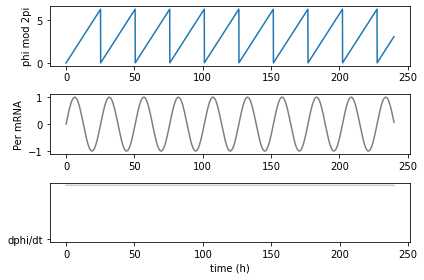

In [31]:
# Simulate 1 neuron without a network
N = 1
VIP_strength = 0
VIP_duration = 0
VIPconn = np.zeros( (N,N) )
AVPconn = np.zeros( (N,N) )

end_time = 240
dt = 0.1
ts = np.arange(0,end_time,dt)
ps0 = np.zeros( (N,) )
pobj = Parameters_VipAVP( N, VIPconn = VIPconn, AVPconn = AVPconn, VIP_duration=VIP_duration )
model = lambda t,ps: model_vip_avp( t, ps, pobj )
b = time.time()
sol = integrate.solve_ivp( fun = model, t_span = (0, end_time), y0=ps0, method="LSODA", t_eval = ts, max_step=0.01 )
dur = time.time() - b
print( f"took {dur} seconds to simulate" )
plot_VIP_AVP( pobj, sol )


took 10.883963823318481 seconds to simulate


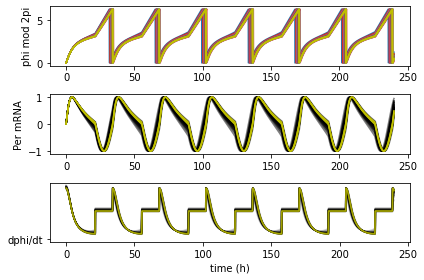

In [39]:
# Simulate and plot with VIP-AVP network (V2 for VIP, V1 for AVP), but make AVP strength zero.
N = 36
VIP_strength = 0.2
AVP_strength = 0.0
VIP_duration = np.pi
VIPconn = VIP_conn_v2( N, VIP_strength )
AVPconn = AVP_conn_v1( N, AVP_strength )


end_time = 240
dt = 0.1
ts = np.arange(0,end_time,dt)
ps0 = np.zeros( (N,) )
pobj = Parameters_VipAVP( N, VIPconn = VIPconn, AVPconn = AVPconn, VIP_duration=VIP_duration )
model = lambda t,ps: model_vip_avp( t, ps, pobj )
b = time.time()
sol = integrate.solve_ivp( fun = model, t_span = (0, end_time), y0=ps0, method="LSODA", t_eval = ts, max_step=0.01 )
dur = time.time() - b
print( f"took {dur} seconds to simulate" )
plot_VIP_AVP( pobj, sol )

took 10.852813005447388 seconds to simulate


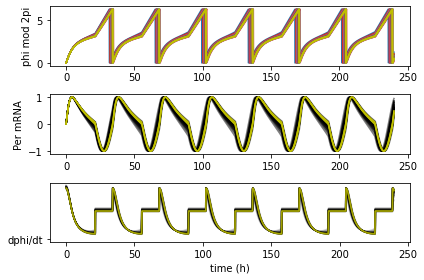

In [40]:
# Simulate and plot with VIP-AVP network (V2 for VIP, V1 for AVP)
N = 36
VIP_strength = 0.2
AVP_strenght = 0.1
VIP_duration = np.pi
VIPconn = VIP_conn_v2( N, VIP_strength )
AVPconn = AVP_conn_v1( N, AVP_strength )


end_time = 240
dt = 0.1
ts = np.arange(0,end_time,dt)
ps0 = np.zeros( (N,) )
pobj = Parameters_VipAVP( N, VIPconn = VIPconn, AVPconn = AVPconn, VIP_duration=VIP_duration )
model = lambda t,ps: model_vip_avp( t, ps, pobj )
b = time.time()
sol = integrate.solve_ivp( fun = model, t_span = (0, end_time), y0=ps0, method="LSODA", t_eval = ts, max_step=0.01 )
dur = time.time() - b
print( f"took {dur} seconds to simulate" )
plot_VIP_AVP( pobj, sol )

*Activity*

Adjust several parameters (one at a time), e.g. VIP strength, AVP strength, AVP VRC shift. Examine the effect on the synchrony.

In [ ]:
# You code here.